In [1]:
import time
import copy
import glob
import random

import numpy as np 
import pandas as pd 
from PIL import Image

from tqdm.auto import tqdm
from matplotlib import pyplot as plt 
from sklearn.model_selection import train_test_split

In [2]:
import torch
import torch.nn as nn
from torch.optim import Adam 
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import resnet18, vgg16

In [3]:
train_normal = glob.glob("../data/chest_xray/train/NORMAL/*")
train_pneumonia = glob.glob("../data/chest_xray/train/PNEUMONIA/*")

test_normal = glob.glob("../data/chest_xray/test/NORMAL/*")
test_pneumonia = glob.glob("../data/chest_xray/test/PNEUMONIA/*")


In [4]:
# train_normal
len(train_normal)

1341

In [5]:
print(len(train_normal), len(train_pneumonia), len(test_normal), len(test_pneumonia))

1341 3875 234 390


We can see the data Imbalance in Train Normal and Train Pneumonia

Will mix the normal and pneumonia into single train and test folder

In [6]:
train_paths = train_normal + train_pneumonia
test_paths = test_normal + test_pneumonia

In [7]:
print(len(train_paths), len(test_paths))

5216 624


Set the labels to Normal as '0' and Pneumonia as '1'

In [8]:
train_labels = [0] * len(train_normal) + [1] * len(train_pneumonia)

In [9]:
print(np.unique(train_labels))
print(len(train_labels))

[0 1]
5216


In [10]:
test_labels = [0] * len(test_normal) + [1] * len(test_pneumonia)

In [11]:
print(np.unique(test_labels))
print(len(test_labels))

[0 1]
624


Split the Train Data to form validation set with train_test_split
- will use stratify_split : to split the data considering the labels.

In [12]:
train_paths, valid_paths, train_labels, valid_labels = train_test_split(train_paths,
                                                                        train_labels,
                                                                        stratify=train_labels)


In [13]:
# print(len(train_paths), len(valid_paths). len(train_labels), len(valid_labels))
print( len(train_labels), len(valid_labels))

3912 1304


Lets visualize the random images

In [14]:
def show_random_images():
    path_random_normal = random.choice(train_normal)
    path_random_pneumonia = random.choice(train_pneumonia)

    fig = plt.figure(figsize=(10,10))

    ax1 = plt.subplot(1,2,1)
    ax1.imshow(Image.open(path_random_normal).convert("LA"))
    ax1.set_title("Normal X-Ray")

    ax2 = plt.subplot(1, 2, 2)
    ax2.imshow(Image.open(path_random_pneumonia).convert("LA"))
    ax2.set_title("Abnormal X-ray")

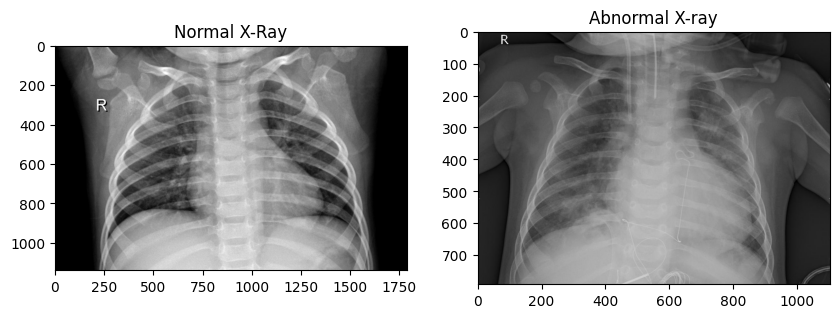

In [15]:
show_random_images()

Define Dataset class to load the data

In [16]:
class XrayDataset(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.paths = paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self,index):
        path = self.paths[index]
        image = Image.open(path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        label = self.labels[index]
        label = torch.tensor([label])

        return image, label

In [17]:
train_dataset = XrayDataset(paths = train_paths, labels = train_labels)

In [18]:
next(iter(train_dataset))   # to check if it retutns 

(<PIL.Image.Image image mode=RGB size=1728x1222>, tensor([0]))

In [19]:
resnet_18 = resnet18()

In [20]:
resnet_18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [21]:
# import os
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

cuda


In [23]:
torch.cuda.empty_cache()

In [24]:
# To check that model is inside GPU memory
! nvidia-smi

Mon Jan 22 10:01:19 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.147.05   Driver Version: 525.147.05   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| N/A   45C    P8     3W /  30W |      8MiB /  6144MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Define Model

In [25]:
class PneumoniaNet(nn.Module):                        #model inherits from nn.Module
    def __init__(self, pretrained=True):
        super(PneumoniaNet, self).__init__()
        self.backbone = resnet18(pretrained=pretrained)        #specify backbone model as an attribute
        #specify FC layer to replace FC layer of resnet18
        self.fc = nn.Linear(in_features=512, out_features=1)   #Binary Classification -> out_features=1

    def forward(self, x):                                  #takes batch of tensor
        x = self.backbone.conv1(x)                         #before layer 1, have conv, bn1, relu, maxpool in layer0
        x = self.backbone.bn1(x)
        x = self.backbone.relu(x)
        x = self.backbone.maxpool(x)

        x = self.backbone.layer1(x)
        x = self.backbone.layer2(x)
        x = self.backbone.layer3(x)
        x = self.backbone.layer4(x)

        x = self.backbone.avgpool(x)

        x = x.view(x.size(0), 512)                         #(size_of_batch, 512) -> change size of data to make 2D
        x = self.fc(x) 

        return x


Define Augumentation Pipeline

In [26]:
image_size = (256, 256)     #actual input images quite big size, resizing will help to speed up

train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size = image_size),
    transforms.RandomRotation(degrees=15),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

valid_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size = image_size),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

Define the Datasets 

In [27]:
train_dataset = XrayDataset(train_paths, train_labels, train_transform)
valid_dataset = XrayDataset(valid_paths, valid_labels, valid_transform)

In [28]:
train_dataset

### Training Pipeline

 Define Parameteres

In [29]:
pretrained = True

model = PneumoniaNet(pretrained=pretrained)

lr = 3e-3
num_epochs = 15
train_batch_size = 16
valid_batch_size = 16

train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, num_workers=5, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=valid_batch_size, num_workers=5, shuffle=False)

# define dataloaders as a dictionary to hold train ans validation data

dataloaders = {
    "train" : train_dataloader,
    "val" : valid_dataloader
}

# logs information not for every epoch but 10 times of it
logging_steps = {
    "train" : len(dataloaders["train"]) // 10,   
    "val" : len(dataloaders["val"]) // 10      
}

# lets put some information about dataset sizes
dataset_sizes = {
    "train" : len(train_dataset),
    "val" : len(valid_dataset)
}

# define batch sizes
batch_sizes = {
    "train" : train_batch_size,
    "val" : valid_batch_size
}

# define Criterion of loss to optimize
criterion = nn.BCEWithLogitsLoss()     # with logits loss , we dont need to change the structure of network at last
optimizer = Adam(model.parameters(), lr=lr)


/home/db/miniconda3/envs/kml/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/db/miniconda3/envs/kml/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Pass the model to Cuda

In [30]:
model.cuda()
# model()

PneumoniaNet(
  (backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tra

Define Training Pipeline

In [31]:
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []

def train_model(model, criterion, optimizer, num_epochs, device=device):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0

    for epoch in tqdm(range(num_epochs), leave=False):
        for phase in ["train", "val"]:
            if phase == "train":
                model.train()
            else: 
                model.eval()

            running_loss =0.0
            running_corrects = 0

            for i, (inputs, labels) in tqdm(enumerate(dataloaders[phase]),
                                            leave= False,
                                            total = len(dataloaders[phase])):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    outputs = model(inputs)

                    preds = outputs.sigmoid() > 0.5

                    loss = criterion(outputs, labels.float())

                    if phase == "train":
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

                #to plot some info inside epoch
                if (i % logging_steps[phase] == 0) & (i > 0):
                    avg_loss = running_loss / ((i+1) * batch_sizes[phase])
                    avg_acc = running_corrects / ((i+1) * batch_sizes[phase])

                    print(f"[{phase}] | {epoch+1}/{num_epochs} | loss : {avg_loss} | acc : {avg_acc}  ")

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print("{} Loss : {:.4f} Acc : {:.4f} ".format(phase, epoch_loss, epoch_acc))
            
            # Store losses and accuracies
            if phase == "train":
                train_losses.append(epoch_loss)
                train_accuracies.append(epoch_acc)
            else:
                valid_losses.append(epoch_loss)
                valid_accuracies.append(epoch_acc)

            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())    #updates model weigths

        print()

    time_elapsed = time.time() - since

    print(f" Training took {time_elapsed} seconds ")

    # Before retuning anything, load the best model inside network
    model.load_state_dict(best_model_wts)

    # Plotting the loss curves
    plt.figure(figsize=(12, 4))

    # Loss curves
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train')
    plt.plot(valid_losses, label='Validation')
    plt.title('Training and Validation Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy curves
    plt.subplot(1, 2, 2)
    # Move scalar tensors to CPU before plotting
    plt.plot([acc.item() for acc in train_accuracies], label='Train')
    plt.plot([acc.item() for acc in valid_accuracies], label='Validation')
    plt.title('Training and Validation Accuracies')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()



    plt.tight_layout()
    plt.show()

    return model

I noticed that in the code you provided earlier, you're using the .item() method to calculate accuracy. This suggests that train_accuracies and valid_accuracies might be scalar tensors.

Assuming train_accuracies and valid_accuracies are tensors containing scalar accuracy values

Start training the model

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/245 [00:00<?, ?it/s]

/home/db/miniconda3/envs/kml/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/db/miniconda3/envs/kml/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, i

[train] | 1/15 | loss : 0.44025134295225143 | acc : 0.824999988079071  
[train] | 1/15 | loss : 0.36839475741191785 | acc : 0.8469387292861938  
[train] | 1/15 | loss : 0.33486816123740315 | acc : 0.8647260069847107  
[train] | 1/15 | loss : 0.3050274926516199 | acc : 0.875644326210022  
[train] | 1/15 | loss : 0.2961882101910666 | acc : 0.87861567735672  
[train] | 1/15 | loss : 0.3010301839431812 | acc : 0.8810344934463501  
[train] | 1/15 | loss : 0.2857896594011043 | acc : 0.8886834383010864  
[train] | 1/15 | loss : 0.2712062667244611 | acc : 0.8941062092781067  
[train] | 1/15 | loss : 0.2662293151501686 | acc : 0.8954492807388306  
[train] | 1/15 | loss : 0.26243318685357503 | acc : 0.8978216052055359  
train Loss : 0.2623 Acc : 0.8978 


  0%|          | 0/82 [00:00<?, ?it/s]

/home/db/miniconda3/envs/kml/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/db/miniconda3/envs/kml/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, i

[val] | 1/15 | loss : 1.771740542517768 | acc : 0.5833333134651184  
[val] | 1/15 | loss : 1.6353549361228943 | acc : 0.5955882668495178  
[val] | 1/15 | loss : 1.6897393870353699 | acc : 0.5949999690055847  
[val] | 1/15 | loss : 1.6869571497946074 | acc : 0.6022727489471436  
[val] | 1/15 | loss : 1.618291123611171 | acc : 0.6036584973335266  
[val] | 1/15 | loss : 1.6395320709870786 | acc : 0.5994898080825806  
[val] | 1/15 | loss : 1.5804161377120436 | acc : 0.6063596606254578  
[val] | 1/15 | loss : 1.549369975236746 | acc : 0.6144230961799622  
[val] | 1/15 | loss : 1.5326564532436737 | acc : 0.6181506514549255  
[val] | 1/15 | loss : 1.5294086778605427 | acc : 0.6149691343307495  
val Loss : 1.5285 Acc : 0.6150 



/home/db/miniconda3/envs/kml/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/245 [00:00<?, ?it/s]

/home/db/miniconda3/envs/kml/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/db/miniconda3/envs/kml/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, i

[train] | 2/15 | loss : 0.22960729166865348 | acc : 0.9325000047683716  
[train] | 2/15 | loss : 0.23075161532175784 | acc : 0.9247449040412903  
[train] | 2/15 | loss : 0.21748474444428537 | acc : 0.9238013625144958  
[train] | 2/15 | loss : 0.21982078749648074 | acc : 0.9220360517501831  
[train] | 2/15 | loss : 0.21643061200079838 | acc : 0.9235537052154541  
[train] | 2/15 | loss : 0.2216497516580697 | acc : 0.9181034564971924  
[train] | 2/15 | loss : 0.216353563691032 | acc : 0.918639063835144  
[train] | 2/15 | loss : 0.21127680439135263 | acc : 0.9213082790374756  
[train] | 2/15 | loss : 0.20243553378649295 | acc : 0.9251152276992798  
[train] | 2/15 | loss : 0.19848403149898863 | acc : 0.9266079068183899  
train Loss : 0.1981 Acc : 0.9266 


  0%|          | 0/82 [00:00<?, ?it/s]

/home/db/miniconda3/envs/kml/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/db/miniconda3/envs/kml/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, i

[val] | 2/15 | loss : 0.4812740973300404 | acc : 0.819444477558136  
[val] | 2/15 | loss : 0.4774971832247341 | acc : 0.8161764740943909  
[val] | 2/15 | loss : 0.5181190145015716 | acc : 0.8125  
[val] | 2/15 | loss : 0.5189316356272409 | acc : 0.814393937587738  
[val] | 2/15 | loss : 0.4994584230660665 | acc : 0.8231707215309143  
[val] | 2/15 | loss : 0.4940753748488365 | acc : 0.8290815949440002  
[val] | 2/15 | loss : 0.5318606607452557 | acc : 0.8234649300575256  
[val] | 2/15 | loss : 0.5443625023015417 | acc : 0.8211538195610046  
[val] | 2/15 | loss : 0.5598739752392858 | acc : 0.8167808055877686  
[val] | 2/15 | loss : 0.5724998119597634 | acc : 0.8179012537002563  
val Loss : 0.5703 Acc : 0.8183 



  0%|          | 0/245 [00:00<?, ?it/s]

/home/db/miniconda3/envs/kml/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/db/miniconda3/envs/kml/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, i

[train] | 3/15 | loss : 0.17972943902015687 | acc : 0.9274999499320984  
[train] | 3/15 | loss : 0.16462923514143546 | acc : 0.9362244606018066  
[train] | 3/15 | loss : 0.1844025590546327 | acc : 0.9289383292198181  
[train] | 3/15 | loss : 0.18711050611334978 | acc : 0.9271907210350037  
[train] | 3/15 | loss : 0.1758233477815616 | acc : 0.9313015937805176  
[train] | 3/15 | loss : 0.17104280626979368 | acc : 0.9331896305084229  
[train] | 3/15 | loss : 0.17417145811418105 | acc : 0.9345414042472839  
[train] | 3/15 | loss : 0.1792742597624428 | acc : 0.9310232996940613  
[train] | 3/15 | loss : 0.17364466709647036 | acc : 0.9331797361373901  
[train] | 3/15 | loss : 0.16748066457506286 | acc : 0.935425341129303  
train Loss : 0.1677 Acc : 0.9353 


  0%|          | 0/82 [00:00<?, ?it/s]

/home/db/miniconda3/envs/kml/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/db/miniconda3/envs/kml/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, i

[val] | 3/15 | loss : 2.254894110891554 | acc : 0.4930555522441864  
[val] | 3/15 | loss : 2.4850334770539226 | acc : 0.4632352888584137  
[val] | 3/15 | loss : 2.5108188438415526 | acc : 0.4699999988079071  
[val] | 3/15 | loss : 2.5470759001645176 | acc : 0.4696969985961914  
[val] | 3/15 | loss : 2.5455400536699995 | acc : 0.46341460943222046  
[val] | 3/15 | loss : 2.586382213903933 | acc : 0.4566326439380646  
[val] | 3/15 | loss : 2.492510048966659 | acc : 0.46820175647735596  
[val] | 3/15 | loss : 2.461459913620582 | acc : 0.4759615361690521  
[val] | 3/15 | loss : 2.436092731070845 | acc : 0.482876718044281  
[val] | 3/15 | loss : 2.4590486508828624 | acc : 0.4760802388191223  
val Loss : 2.4610 Acc : 0.4747 



  0%|          | 0/245 [00:00<?, ?it/s]

/home/db/miniconda3/envs/kml/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/db/miniconda3/envs/kml/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, i

[train] | 4/15 | loss : 0.18623239137232303 | acc : 0.9274999499320984  
[train] | 4/15 | loss : 0.1670781753349061 | acc : 0.9311224222183228  
[train] | 4/15 | loss : 0.16570697541106238 | acc : 0.9332191944122314  
[train] | 4/15 | loss : 0.16779219357239217 | acc : 0.9304123520851135  
[train] | 4/15 | loss : 0.160169058071434 | acc : 0.9338842630386353  
[train] | 4/15 | loss : 0.15433641042688798 | acc : 0.9375  
[train] | 4/15 | loss : 0.15915826601169167 | acc : 0.9371302127838135  
[train] | 4/15 | loss : 0.16093570418617267 | acc : 0.9378238320350647  
[train] | 4/15 | loss : 0.15661805523945713 | acc : 0.940092146396637  
[train] | 4/15 | loss : 0.15621806449678058 | acc : 0.9390560388565063  
train Loss : 0.1558 Acc : 0.9392 


  0%|          | 0/82 [00:00<?, ?it/s]

/home/db/miniconda3/envs/kml/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/db/miniconda3/envs/kml/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, i

[val] | 4/15 | loss : 0.9471703535980649 | acc : 0.7013888955116272  
[val] | 4/15 | loss : 0.897162221810397 | acc : 0.7095588445663452  
[val] | 4/15 | loss : 0.9161931967735291 | acc : 0.7149999737739563  
[val] | 4/15 | loss : 0.8848629611911196 | acc : 0.7310606241226196  
[val] | 4/15 | loss : 0.8529229215005549 | acc : 0.727134108543396  
[val] | 4/15 | loss : 0.8722574023567901 | acc : 0.7232142686843872  
[val] | 4/15 | loss : 0.8371234389773586 | acc : 0.734649121761322  
[val] | 4/15 | loss : 0.8103363768412517 | acc : 0.742307722568512  
[val] | 4/15 | loss : 0.8041475909213497 | acc : 0.7457191944122314  
[val] | 4/15 | loss : 0.7984658225818917 | acc : 0.7461419701576233  
val Loss : 0.7971 Acc : 0.7462 



/home/db/miniconda3/envs/kml/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/245 [00:00<?, ?it/s]

/home/db/miniconda3/envs/kml/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/db/miniconda3/envs/kml/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, i

[train] | 5/15 | loss : 0.10868109162896872 | acc : 0.9549999833106995  
[train] | 5/15 | loss : 0.1528052489406296 | acc : 0.9413264989852905  
[train] | 5/15 | loss : 0.16511721236707821 | acc : 0.9392123222351074  
[train] | 5/15 | loss : 0.1493005854432884 | acc : 0.9439432621002197  
[train] | 5/15 | loss : 0.14979591077455312 | acc : 0.9452478885650635  
[train] | 5/15 | loss : 0.15558474447963566 | acc : 0.9426724314689636  
[train] | 5/15 | loss : 0.14945212898213836 | acc : 0.9437869787216187  
[train] | 5/15 | loss : 0.15172880049312362 | acc : 0.9423574805259705  
[train] | 5/15 | loss : 0.15122251584267563 | acc : 0.9432603716850281  
[train] | 5/15 | loss : 0.1529720543470249 | acc : 0.9429461359977722  
train Loss : 0.1522 Acc : 0.9435 


  0%|          | 0/82 [00:00<?, ?it/s]

/home/db/miniconda3/envs/kml/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/db/miniconda3/envs/kml/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, i

[val] | 5/15 | loss : 0.13357383343908522 | acc : 0.9305555820465088  
[val] | 5/15 | loss : 0.14253252021530094 | acc : 0.9338235259056091  
[val] | 5/15 | loss : 0.1705063822865486 | acc : 0.92249995470047  
[val] | 5/15 | loss : 0.16132194661732877 | acc : 0.9261363744735718  
[val] | 5/15 | loss : 0.1534072272933838 | acc : 0.9298779964447021  
[val] | 5/15 | loss : 0.15767459886870822 | acc : 0.9298469424247742  
[val] | 5/15 | loss : 0.15444476291406573 | acc : 0.9320175647735596  
[val] | 5/15 | loss : 0.1531386057058206 | acc : 0.932692289352417  
[val] | 5/15 | loss : 0.1534561904734128 | acc : 0.9323630332946777  
[val] | 5/15 | loss : 0.15487062323976447 | acc : 0.9336419701576233  
val Loss : 0.1547 Acc : 0.9340 



  0%|          | 0/245 [00:00<?, ?it/s]

/home/db/miniconda3/envs/kml/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/db/miniconda3/envs/kml/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, i

[train] | 6/15 | loss : 0.10944756384938956 | acc : 0.9649999737739563  
[train] | 6/15 | loss : 0.133773865653392 | acc : 0.9502550959587097  
[train] | 6/15 | loss : 0.12690260961702834 | acc : 0.9511986374855042  
[train] | 6/15 | loss : 0.13274311544085593 | acc : 0.9484536051750183  
[train] | 6/15 | loss : 0.1315791558104852 | acc : 0.9488636255264282  
[train] | 6/15 | loss : 0.13637511048080592 | acc : 0.9456896781921387  
[train] | 6/15 | loss : 0.142250663396963 | acc : 0.94415682554245  
[train] | 6/15 | loss : 0.13696099174995496 | acc : 0.9459196925163269  
[train] | 6/15 | loss : 0.12980129299384932 | acc : 0.9493087530136108  
[train] | 6/15 | loss : 0.12492475623295823 | acc : 0.952282190322876  
train Loss : 0.1241 Acc : 0.9527 


  0%|          | 0/82 [00:00<?, ?it/s]

/home/db/miniconda3/envs/kml/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/db/miniconda3/envs/kml/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, i

[val] | 6/15 | loss : 0.09752758344014485 | acc : 0.9513888955116272  
[val] | 6/15 | loss : 0.18435605724944787 | acc : 0.9448529481887817  
[val] | 6/15 | loss : 0.2661733318865299 | acc : 0.9350000023841858  
[val] | 6/15 | loss : 0.24844968945465304 | acc : 0.9280303120613098  
[val] | 6/15 | loss : 0.24250369764887159 | acc : 0.9298779964447021  
[val] | 6/15 | loss : 0.24542359313309878 | acc : 0.9311224222183228  
[val] | 6/15 | loss : 0.2913888352780129 | acc : 0.9298245906829834  
[val] | 6/15 | loss : 0.28519350884374806 | acc : 0.9269230961799622  
[val] | 6/15 | loss : 0.30263123935094893 | acc : 0.9229452013969421  
[val] | 6/15 | loss : 0.3237381712777862 | acc : 0.9205247163772583  
val Loss : 0.3219 Acc : 0.9210 



  0%|          | 0/245 [00:00<?, ?it/s]

/home/db/miniconda3/envs/kml/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/db/miniconda3/envs/kml/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, i

[train] | 7/15 | loss : 0.09329854248091579 | acc : 0.9549999833106995  
[train] | 7/15 | loss : 0.11050887722331955 | acc : 0.9489795565605164  
[train] | 7/15 | loss : 0.11857476688232528 | acc : 0.9477739930152893  
[train] | 7/15 | loss : 0.1106805920303252 | acc : 0.9510309100151062  
[train] | 7/15 | loss : 0.11371734784146355 | acc : 0.9529958367347717  
[train] | 7/15 | loss : 0.12054908825084568 | acc : 0.9495689868927002  
[train] | 7/15 | loss : 0.12120040524585625 | acc : 0.9511834383010864  
[train] | 7/15 | loss : 0.12956841948919887 | acc : 0.9485103487968445  
[train] | 7/15 | loss : 0.12466249354655773 | acc : 0.9516128897666931  
[train] | 7/15 | loss : 0.12514977505492408 | acc : 0.9520228505134583  
train Loss : 0.1271 Acc : 0.9512 


/home/db/miniconda3/envs/kml/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/82 [00:00<?, ?it/s]

/home/db/miniconda3/envs/kml/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/db/miniconda3/envs/kml/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, i

[val] | 7/15 | loss : 0.22979841712448332 | acc : 0.8888888955116272  
[val] | 7/15 | loss : 0.24529560655355453 | acc : 0.8970588445663452  
[val] | 7/15 | loss : 0.25891347616910937 | acc : 0.8924999833106995  
[val] | 7/15 | loss : 0.23944377199266897 | acc : 0.8996212482452393  
[val] | 7/15 | loss : 0.24371325869749233 | acc : 0.8963414430618286  
[val] | 7/15 | loss : 0.2551917385842119 | acc : 0.8941326141357422  
[val] | 7/15 | loss : 0.2512317646229476 | acc : 0.8914473652839661  
[val] | 7/15 | loss : 0.24711155891418457 | acc : 0.8903846144676208  
[val] | 7/15 | loss : 0.24518095569251336 | acc : 0.8895547986030579  
[val] | 7/15 | loss : 0.2456287329579577 | acc : 0.8904321193695068  
val Loss : 0.2451 Acc : 0.8911 



  0%|          | 0/245 [00:00<?, ?it/s]

/home/db/miniconda3/envs/kml/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/db/miniconda3/envs/kml/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, i

[train] | 8/15 | loss : 0.14332025352865457 | acc : 0.9449999928474426  
[train] | 8/15 | loss : 0.1396387180085389 | acc : 0.9489795565605164  
[train] | 8/15 | loss : 0.13762543609442368 | acc : 0.9494863152503967  
[train] | 8/15 | loss : 0.13686561249388554 | acc : 0.9484536051750183  
[train] | 8/15 | loss : 0.1244430165961077 | acc : 0.9524793028831482  
[train] | 8/15 | loss : 0.11425520734668805 | acc : 0.9564655423164368  
[train] | 8/15 | loss : 0.12014144822161578 | acc : 0.9552515149116516  
[train] | 8/15 | loss : 0.12248695491200284 | acc : 0.9530439972877502  
[train] | 8/15 | loss : 0.12835508559225342 | acc : 0.9527649879455566  
[train] | 8/15 | loss : 0.12607780082298142 | acc : 0.952282190322876  
train Loss : 0.1278 Acc : 0.9522 


  0%|          | 0/82 [00:00<?, ?it/s]

/home/db/miniconda3/envs/kml/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/db/miniconda3/envs/kml/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, i

[val] | 8/15 | loss : 0.09808428828707999 | acc : 0.9652777910232544  
[val] | 8/15 | loss : 0.11844633620999315 | acc : 0.9558823704719543  
[val] | 8/15 | loss : 0.14080670991912483 | acc : 0.9524999856948853  
[val] | 8/15 | loss : 0.1198135696661969 | acc : 0.9583333730697632  
[val] | 8/15 | loss : 0.11521933771806156 | acc : 0.9618902206420898  
[val] | 8/15 | loss : 0.11542469151888271 | acc : 0.9591836333274841  
[val] | 8/15 | loss : 0.12499092118161027 | acc : 0.9561403393745422  
[val] | 8/15 | loss : 0.11685108119048751 | acc : 0.9596154093742371  
[val] | 8/15 | loss : 0.11539848903449226 | acc : 0.9589040875434875  
[val] | 8/15 | loss : 0.12091674544722025 | acc : 0.957561731338501  
val Loss : 0.1202 Acc : 0.9578 



  0%|          | 0/245 [00:00<?, ?it/s]

/home/db/miniconda3/envs/kml/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/db/miniconda3/envs/kml/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, i

[train] | 9/15 | loss : 0.12394474845379591 | acc : 0.9549999833106995  
[train] | 9/15 | loss : 0.1059898719837775 | acc : 0.9630101919174194  
[train] | 9/15 | loss : 0.14003730002688627 | acc : 0.9477739930152893  
[train] | 9/15 | loss : 0.14222432585605949 | acc : 0.9484536051750183  
[train] | 9/15 | loss : 0.14140330874630488 | acc : 0.9483470916748047  
[train] | 9/15 | loss : 0.13783157311765284 | acc : 0.9495689868927002  
[train] | 9/15 | loss : 0.1373346113825779 | acc : 0.948964536190033  
[train] | 9/15 | loss : 0.13567085816992996 | acc : 0.9491580128669739  
[train] | 9/15 | loss : 0.13036582377322944 | acc : 0.9504608511924744  
[train] | 9/15 | loss : 0.130409568760745 | acc : 0.9507262110710144  
train Loss : 0.1302 Acc : 0.9512 


  0%|          | 0/82 [00:00<?, ?it/s]

/home/db/miniconda3/envs/kml/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/db/miniconda3/envs/kml/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, i

[val] | 9/15 | loss : 0.11447322120269139 | acc : 0.9513888955116272  
[val] | 9/15 | loss : 0.13298553228378296 | acc : 0.9485294222831726  
[val] | 9/15 | loss : 0.1304819628596306 | acc : 0.9449999928474426  
[val] | 9/15 | loss : 0.1336349228284124 | acc : 0.946969747543335  
[val] | 9/15 | loss : 0.12516700553639634 | acc : 0.9527438879013062  
[val] | 9/15 | loss : 0.1254159028888965 | acc : 0.9528061151504517  
[val] | 9/15 | loss : 0.1354606820335775 | acc : 0.9517543911933899  
[val] | 9/15 | loss : 0.12960641187830613 | acc : 0.9538461565971375  
[val] | 9/15 | loss : 0.13427697774022818 | acc : 0.9529109597206116  
[val] | 9/15 | loss : 0.13688326115363542 | acc : 0.9506173133850098  
val Loss : 0.1361 Acc : 0.9509 



/home/db/miniconda3/envs/kml/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/245 [00:00<?, ?it/s]

/home/db/miniconda3/envs/kml/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/db/miniconda3/envs/kml/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, i

[train] | 10/15 | loss : 0.06775871738791465 | acc : 0.9699999690055847  
[train] | 10/15 | loss : 0.08241462726526115 | acc : 0.9630101919174194  
[train] | 10/15 | loss : 0.10493678426408298 | acc : 0.960616409778595  
[train] | 10/15 | loss : 0.0970661560788789 | acc : 0.9632731676101685  
[train] | 10/15 | loss : 0.09374889829734817 | acc : 0.9643594622612  
[train] | 10/15 | loss : 0.09140648634237206 | acc : 0.9676724076271057  
[train] | 10/15 | loss : 0.09073428786084188 | acc : 0.968934953212738  
[train] | 10/15 | loss : 0.09766928109321067 | acc : 0.9669688940048218  
[train] | 10/15 | loss : 0.10223770791274164 | acc : 0.9642857313156128  
[train] | 10/15 | loss : 0.09946707956380833 | acc : 0.9647303223609924  
train Loss : 0.0990 Acc : 0.9650 


  0%|          | 0/82 [00:00<?, ?it/s]

/home/db/miniconda3/envs/kml/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/db/miniconda3/envs/kml/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, i

[val] | 10/15 | loss : 0.0568410384003073 | acc : 0.9791666865348816  
[val] | 10/15 | loss : 0.06883992299930576 | acc : 0.9742646813392639  
[val] | 10/15 | loss : 0.08540077706798911 | acc : 0.9674999713897705  
[val] | 10/15 | loss : 0.0789417983314982 | acc : 0.9715909361839294  
[val] | 10/15 | loss : 0.06885154167667212 | acc : 0.9740853309631348  
[val] | 10/15 | loss : 0.06585298276658418 | acc : 0.9757652878761292  
[val] | 10/15 | loss : 0.07319852725496483 | acc : 0.9725877046585083  
[val] | 10/15 | loss : 0.06851608345034317 | acc : 0.9750000238418579  
[val] | 10/15 | loss : 0.06981339273266239 | acc : 0.9751712083816528  
[val] | 10/15 | loss : 0.07433224445996507 | acc : 0.9737654328346252  
val Loss : 0.0739 Acc : 0.9739 



/home/db/miniconda3/envs/kml/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/245 [00:00<?, ?it/s]

/home/db/miniconda3/envs/kml/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/db/miniconda3/envs/kml/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, i

[train] | 11/15 | loss : 0.12909959820099176 | acc : 0.9449999928474426  
[train] | 11/15 | loss : 0.10791179597168704 | acc : 0.9540815949440002  
[train] | 11/15 | loss : 0.09095162483991111 | acc : 0.9614725708961487  
[train] | 11/15 | loss : 0.10550646789458379 | acc : 0.9574741721153259  
[train] | 11/15 | loss : 0.10309642892184644 | acc : 0.9591941833496094  
[train] | 11/15 | loss : 0.0989547826333678 | acc : 0.9629310369491577  
[train] | 11/15 | loss : 0.09821089171286473 | acc : 0.9633876085281372  
[train] | 11/15 | loss : 0.09823788240083875 | acc : 0.9634066820144653  
[train] | 11/15 | loss : 0.10211862066078262 | acc : 0.963421642780304  
[train] | 11/15 | loss : 0.10079249064631265 | acc : 0.9644709825515747  
train Loss : 0.1003 Acc : 0.9647 


  0%|          | 0/82 [00:00<?, ?it/s]

/home/db/miniconda3/envs/kml/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/db/miniconda3/envs/kml/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, i

[val] | 11/15 | loss : 0.07663023132934338 | acc : 0.9722222089767456  
[val] | 11/15 | loss : 0.0776687433860977 | acc : 0.9705882668495178  
[val] | 11/15 | loss : 0.084241688484326 | acc : 0.9674999713897705  
[val] | 11/15 | loss : 0.07222563743055092 | acc : 0.9734848737716675  
[val] | 11/15 | loss : 0.06536474799532897 | acc : 0.977134108543396  
[val] | 11/15 | loss : 0.0656497594662847 | acc : 0.9770407676696777  
[val] | 11/15 | loss : 0.07267557882311705 | acc : 0.9747807383537292  
[val] | 11/15 | loss : 0.07209790241188155 | acc : 0.9730769395828247  
[val] | 11/15 | loss : 0.07226662639821943 | acc : 0.971746563911438  
[val] | 11/15 | loss : 0.07578876072161451 | acc : 0.9699074029922485  
val Loss : 0.0754 Acc : 0.9701 



  0%|          | 0/245 [00:00<?, ?it/s]

/home/db/miniconda3/envs/kml/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/db/miniconda3/envs/kml/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, i

[train] | 12/15 | loss : 0.0662616496346891 | acc : 0.9799999594688416  
[train] | 12/15 | loss : 0.07367800926903681 | acc : 0.9770407676696777  
[train] | 12/15 | loss : 0.08744400779219115 | acc : 0.9691780805587769  
[train] | 12/15 | loss : 0.08186005798562132 | acc : 0.9710051417350769  
[train] | 12/15 | loss : 0.09214247005398978 | acc : 0.9669421315193176  
[train] | 12/15 | loss : 0.09187019656508646 | acc : 0.9663792848587036  
[train] | 12/15 | loss : 0.09613750806386918 | acc : 0.9652367234230042  
[train] | 12/15 | loss : 0.0969214513535983 | acc : 0.9640544056892395  
[train] | 12/15 | loss : 0.09927845073752277 | acc : 0.963421642780304  
[train] | 12/15 | loss : 0.09911953915621606 | acc : 0.9631743431091309  
train Loss : 0.0987 Acc : 0.9632 


/home/db/miniconda3/envs/kml/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


  0%|          | 0/82 [00:00<?, ?it/s]

/home/db/miniconda3/envs/kml/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/db/miniconda3/envs/kml/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, i

[val] | 12/15 | loss : 0.09329245793115762 | acc : 0.9652777910232544  
[val] | 12/15 | loss : 0.09152530276161783 | acc : 0.9595588445663452  
[val] | 12/15 | loss : 0.09690261889249087 | acc : 0.9574999809265137  
[val] | 12/15 | loss : 0.08032751199083799 | acc : 0.9659091234207153  
[val] | 12/15 | loss : 0.079722474261028 | acc : 0.9664633870124817  
[val] | 12/15 | loss : 0.0759487804785675 | acc : 0.9681122303009033  
[val] | 12/15 | loss : 0.0790195735824997 | acc : 0.9660087823867798  
[val] | 12/15 | loss : 0.074738883986496 | acc : 0.9682692289352417  
[val] | 12/15 | loss : 0.07660820740849188 | acc : 0.9674657583236694  
[val] | 12/15 | loss : 0.08334903505251363 | acc : 0.9660493731498718  
val Loss : 0.0829 Acc : 0.9663 



  0%|          | 0/245 [00:00<?, ?it/s]

/home/db/miniconda3/envs/kml/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/db/miniconda3/envs/kml/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, i

[train] | 13/15 | loss : 0.07594988564029335 | acc : 0.9749999642372131  
[train] | 13/15 | loss : 0.10042573316783017 | acc : 0.964285671710968  
[train] | 13/15 | loss : 0.0905826665167633 | acc : 0.9691780805587769  
[train] | 13/15 | loss : 0.0859629082896737 | acc : 0.969716489315033  
[train] | 13/15 | loss : 0.08685021767054092 | acc : 0.9684916734695435  
[train] | 13/15 | loss : 0.09027499431294614 | acc : 0.9689655303955078  
[train] | 13/15 | loss : 0.08935045043678855 | acc : 0.9693047404289246  
[train] | 13/15 | loss : 0.09009560732740349 | acc : 0.9695595502853394  
[train] | 13/15 | loss : 0.08824386330072506 | acc : 0.9697580933570862  
[train] | 13/15 | loss : 0.08665195794938388 | acc : 0.9701763987541199  
train Loss : 0.0869 Acc : 0.9696 


  0%|          | 0/82 [00:00<?, ?it/s]

/home/db/miniconda3/envs/kml/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/db/miniconda3/envs/kml/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, i

[val] | 13/15 | loss : 0.06816906093930204 | acc : 0.9722222089767456  
[val] | 13/15 | loss : 0.07307248933733825 | acc : 0.9632353186607361  
[val] | 13/15 | loss : 0.0806851294543594 | acc : 0.9649999737739563  
[val] | 13/15 | loss : 0.07423661836902752 | acc : 0.9659091234207153  
[val] | 13/15 | loss : 0.0659921137934051 | acc : 0.9725609421730042  
[val] | 13/15 | loss : 0.06312874607190642 | acc : 0.9719387292861938  
[val] | 13/15 | loss : 0.07096263345968175 | acc : 0.9714912176132202  
[val] | 13/15 | loss : 0.07133679498488513 | acc : 0.9711538553237915  
[val] | 13/15 | loss : 0.07189738813290143 | acc : 0.9726027250289917  
[val] | 13/15 | loss : 0.0760654045044686 | acc : 0.9714506268501282  
val Loss : 0.0756 Acc : 0.9716 



  0%|          | 0/245 [00:00<?, ?it/s]

/home/db/miniconda3/envs/kml/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/db/miniconda3/envs/kml/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, i

[train] | 14/15 | loss : 0.05846229815389961 | acc : 0.9724999666213989  
[train] | 14/15 | loss : 0.08408097067268147 | acc : 0.9655612111091614  
[train] | 14/15 | loss : 0.08463252919298686 | acc : 0.9640411138534546  
[train] | 14/15 | loss : 0.08579678226084708 | acc : 0.9671391248703003  
[train] | 14/15 | loss : 0.08557566746680666 | acc : 0.9674586653709412  
[train] | 14/15 | loss : 0.08155645627512371 | acc : 0.9685344696044922  
[train] | 14/15 | loss : 0.08959615679620352 | acc : 0.9652367234230042  
[train] | 14/15 | loss : 0.0894465338953872 | acc : 0.9650259017944336  
[train] | 14/15 | loss : 0.08769556859342922 | acc : 0.9654377698898315  
[train] | 14/15 | loss : 0.08746858490428103 | acc : 0.967064380645752  
train Loss : 0.0864 Acc : 0.9675 


  0%|          | 0/82 [00:00<?, ?it/s]

/home/db/miniconda3/envs/kml/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/db/miniconda3/envs/kml/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, i

[val] | 14/15 | loss : 0.09740290144044492 | acc : 0.9652777910232544  
[val] | 14/15 | loss : 0.14309668379342733 | acc : 0.9595588445663452  
[val] | 14/15 | loss : 0.1371153994835913 | acc : 0.9599999785423279  
[val] | 14/15 | loss : 0.15063625035426495 | acc : 0.9564394354820251  
[val] | 14/15 | loss : 0.13449408155979542 | acc : 0.9603658318519592  
[val] | 14/15 | loss : 0.12110639209336392 | acc : 0.9630101919174194  
[val] | 14/15 | loss : 0.13543896889926768 | acc : 0.9572368264198303  
[val] | 14/15 | loss : 0.14171580007263962 | acc : 0.9557692408561707  
[val] | 14/15 | loss : 0.140012549974777 | acc : 0.9563356041908264  
[val] | 14/15 | loss : 0.13864458799448418 | acc : 0.9567901492118835  
val Loss : 0.1378 Acc : 0.9571 



  0%|          | 0/245 [00:00<?, ?it/s]

/home/db/miniconda3/envs/kml/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/db/miniconda3/envs/kml/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, i

[train] | 15/15 | loss : 0.07147517916280777 | acc : 0.9724999666213989  
[train] | 15/15 | loss : 0.06611958732923531 | acc : 0.9757652878761292  
[train] | 15/15 | loss : 0.08395755308208196 | acc : 0.9691780805587769  
[train] | 15/15 | loss : 0.08057535228981953 | acc : 0.9710051417350769  
[train] | 15/15 | loss : 0.08269050282480056 | acc : 0.9710743427276611  
[train] | 15/15 | loss : 0.0818065164578629 | acc : 0.9702585935592651  
[train] | 15/15 | loss : 0.0801866695604469 | acc : 0.9704142212867737  
[train] | 15/15 | loss : 0.08063983069395 | acc : 0.9705310463905334  
[train] | 15/15 | loss : 0.08148739289509536 | acc : 0.9697580933570862  
[train] | 15/15 | loss : 0.07990529070824724 | acc : 0.9706950783729553  
train Loss : 0.0806 Acc : 0.9703 


  0%|          | 0/82 [00:00<?, ?it/s]

/home/db/miniconda3/envs/kml/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
/home/db/miniconda3/envs/kml/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, i

[val] | 15/15 | loss : 0.07668337678640252 | acc : 0.9513888955116272  
[val] | 15/15 | loss : 0.09775639167877243 | acc : 0.9522058963775635  
[val] | 15/15 | loss : 0.08968352009542287 | acc : 0.9549999833106995  
[val] | 15/15 | loss : 0.07881221285964729 | acc : 0.9640151858329773  
[val] | 15/15 | loss : 0.07920471903095704 | acc : 0.9634146094322205  
[val] | 15/15 | loss : 0.07590400405247144 | acc : 0.9655612111091614  
[val] | 15/15 | loss : 0.0775848873523309 | acc : 0.9627193212509155  
[val] | 15/15 | loss : 0.07462645812461582 | acc : 0.9644230604171753  
[val] | 15/15 | loss : 0.07299609604444712 | acc : 0.9640411138534546  
[val] | 15/15 | loss : 0.07568268314360377 | acc : 0.9621913433074951  
val Loss : 0.0753 Acc : 0.9624 

 Training took 1555.3586049079895 seconds 


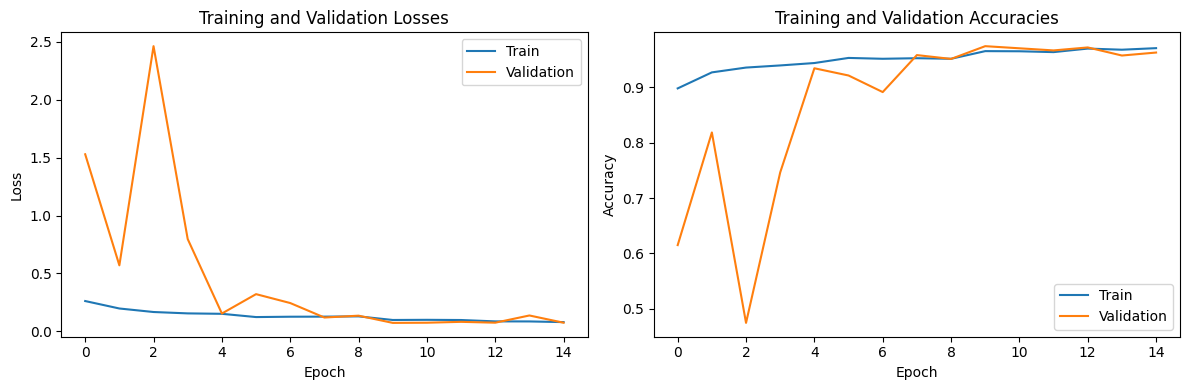

In [32]:
model = train_model(model, criterion, optimizer, num_epochs )

Lets see how the model performs on Test Data

In [33]:
test_paths = glob.glob("../data/chest_xray/test/NORMAL/*")  + glob.glob("../data/chest_xray/test/PNEUMONIA/*")
test_labels = [0] * len(glob.glob("../data/chest_xray/test/NORMAL/*"))  + [1] * len(glob.glob("../data/chest_xray/test/PNEUMONIA/*"))

In [34]:
len(test_paths), len(test_labels)

(624, 624)

In [35]:
test_dataset = XrayDataset(test_paths, test_labels, valid_transform)

In [36]:
test_dataloader = DataLoader(test_dataset, batch_size = 32, shuffle=False, drop_last=False)

In [37]:
y_pred = []
y_true = []

for i, (tensors, labels) in tqdm(enumerate(test_dataloader), leave=False, total=len(test_dataloader)):
    with torch.no_grad():
        # Move input tensor to the same device as the model
        tensors = tensors.to(device)
        
        # Move the model to the same device as the input tensor
        model = model.to(device)
        
        # Forward pass
        predictions = model(tensors)
        predictions = predictions.sigmoid()
        predictions = predictions > 0.5    # convert to binary target
        y_pred.append(predictions)

        y_true.append(labels)


  0%|          | 0/20 [00:00<?, ?it/s]

/home/db/miniconda3/envs/kml/lib/python3.9/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [38]:
y_pred[0]

tensor([[ True],
        [False],
        [False],
        [ True],
        [ True],
        [False],
        [False],
        [ True],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [False],
        [ True],
        [ True],
        [ True],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [False],
        [ True],
        [False],
        [False],
        [False]], device='cuda:0')

In [39]:
# concatenate all tensors together 
y_pred = torch.cat(y_pred)
y_true = torch.cat(y_true)

In [40]:
y_pred.shape, y_true.shape

(torch.Size([624, 1]), torch.Size([624, 1]))

In [41]:
# convert these vectors to tensors
y_pred = y_pred.cpu().numpy()
y_true = y_true.numpy()

In [42]:
# caste it as integers
y_pred = y_pred.astype(np.int64)
y_true = y_true.astype(np.int64)

In [43]:
#reshape
y_pred = y_pred.reshape(-1)
y_true = y_true.reshape(-1)

In [44]:
y_pred.shape, y_true.shape

((624,), (624,))

In [45]:
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred)

0.8397435897435898